<a href="https://colab.research.google.com/github/shangzhu-cmu/BML_projects_Instructions/blob/main/neuralECM_Torch_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NeuralECM Demo: Implementing Simple Circuit Model with torchdiffeq

Author: Shang Zhu

install packages: torchdiffeq (https://github.com/rtqichen/torchdiffeq)

In [1]:
! pip install torchdiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
import torch
from torchdiffeq import odeint

# Define the differential equation describing the battery behavior
def ECM( t, y, params, I):
    # Unpack the parameters
    R0, R1, C1, E0= params
    #y: I1, the current passing the resistor R1

    dydt = (I(t)-y)/(0.001*R1*C1)
    return dydt

# Define the MSE loss function
def mse_loss(y_pred, y_true):
    return torch.mean((y_pred - y_true)**2)

# Define the battery parameters and input current
R0_true = 100  # true internal resistance in milliohms
R1_true = 10  # true resistance in milliohms
C1_true = 100.0  # true capacitance in farads
E0_true = 3.7  # true open-circuit voltage in volts

# Generate noisy training data
y0=torch.tensor([0.0])
t_train = torch.linspace(0, 5, 100)  # time points
I_true = lambda t: 0.5+0.005 * torch.sin(2 * torch.pi * t) 
y_true = odeint(lambda t, y: ECM(t, y, [R0_true, R1_true, C1_true, E0_true], I_true), y0, t_train)

# y_train = y_true + 0.01 * torch.randn_like(y_true)  # add noise
V_true=E0_true-0.001*R0_true*torch.reshape(I_true(t_train), (-1,1))-0.001*R1_true*y_true
V_train = V_true + 0.0001 * torch.randn_like(V_true)  # add noise

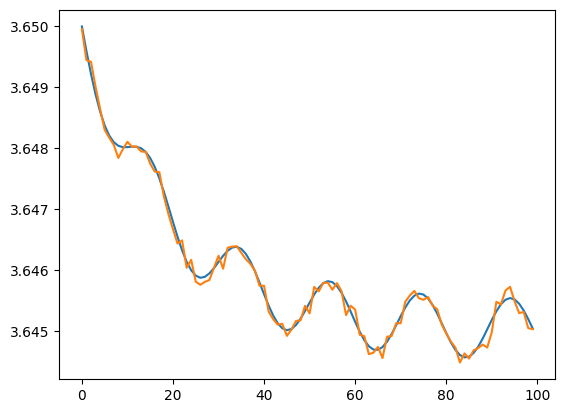

In [76]:
import matplotlib.pyplot as plt

plt.plot(V_true)
plt.plot(V_train)

# plt.plot(y_true)

In [79]:
# Define the model and optimizer
R0_pred = torch.nn.Parameter(torch.tensor(200.0))  # predicted internal resistance in ohms
R1_pred = torch.nn.Parameter(torch.tensor(20.0))  # predicted resistance in ohms
C1_pred = torch.nn.Parameter(torch.tensor(50.0))  # predicted capacitance in farads
E0_pred = torch.nn.Parameter(torch.tensor(4.0))  # predicted open-circuit voltage in volts
optimizer = torch.optim.Adam([R0_pred, R1_pred, C1_pred, E0_pred], lr=1e-1)

# Train the model
for i in range(1000):
    # Predict the battery response for the current parameters and input current
    y_pred = odeint(lambda t, y: ECM(t, y, [R0_pred, R1_pred, C1_pred, E0_pred], I_true), y0, t_train)
    V_pred=E0_pred-0.001*R0_pred*torch.reshape(I_true(t_train), (-1,1))-0.001*R1_pred*y_pred
    
    # Compute the loss and gradients
    loss = mse_loss(V_pred, V_train)
    if i%100==0:
        print('loss function:', loss)
        print('C1, R0, R1, E0 value:', C1_pred.detach().numpy(), R0_pred.detach().numpy(), R1_pred.detach().numpy(), E0_pred.detach().numpy())
    optimizer.zero_grad()
    loss.backward()
    
    # Update the parameters
    optimizer.step()

loss function: tensor(0.0605, grad_fn=<MeanBackward0>)
C1, R0, R1, E0 value: 50.0 200.0 20.0 4.0
loss function: tensor(1.6945e-06, grad_fn=<MeanBackward0>)
C1, R0, R1, E0 value: 49.73046 200.24597 20.158804 3.7538743
loss function: tensor(1.5535e-06, grad_fn=<MeanBackward0>)
C1, R0, R1, E0 value: 49.64829 200.24547 19.992592 3.7541032
loss function: tensor(1.4756e-06, grad_fn=<MeanBackward0>)
C1, R0, R1, E0 value: 49.54134 200.24547 19.777573 3.7540464
loss function: tensor(1.3868e-06, grad_fn=<MeanBackward0>)
C1, R0, R1, E0 value: 49.41528 200.24547 19.524302 3.753973
loss function: tensor(1.2908e-06, grad_fn=<MeanBackward0>)
C1, R0, R1, E0 value: 49.273975 200.24547 19.240187 3.7538896
loss function: tensor(1.1910e-06, grad_fn=<MeanBackward0>)
C1, R0, R1, E0 value: 49.120792 200.24547 18.93122 3.7537973
loss function: tensor(1.0900e-06, grad_fn=<MeanBackward0>)
C1, R0, R1, E0 value: 48.958923 200.24547 18.602705 3.7536983
loss function: tensor(9.9034e-07, grad_fn=<MeanBackward0>)
C1,